In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
import os
import pandas as pd

root_dir = 'db'

In [2]:
ct_idx = 1
vol_dim = 9
with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)

#### Porosity check

In [5]:
for i in range(1):
    phys_generate = sim_results[i]['generate']

    print(30*"--")
    print('original',sim_results[i]['original']['porosity'])
    

    for phys_emsemble in phys_generate:
        if not phys_emsemble:
            continue
        print(phys_emsemble['porosity'])

------------------------------------------------------------
original 0.1954463702333971
0.20882028545698839
0.20841507983632865
0.21103332268357766


#### Check Vol_dim = 9

$64*9$ -> $576^3$

In [52]:
k_gen, k_real, k_compare,k_compare_real = [], [], [],[]

for ct_idx in range(6):
    with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
        # Deserialize the data from the file and assign it to a variable
        sim_results = pickle.load(file)
    
    sample_idx = 0

    phys_generate = sim_results[i]['generate']
    phys_real = sim_results[i]['original']

    for phys_emsemble in phys_generate:
        if not phys_emsemble:
            continue
        k_gen.append(phys_emsemble['kabs'][0])
        k_real.append(phys_real['kabs'][0])


    compare_results = sim_results['compare']

    for compare_phys in compare_results:
        if not compare_phys:
            continue
        k_compare.append(compare_phys['kabs'][0])
        k_compare_real.append(phys_real['kabs'][0])
    

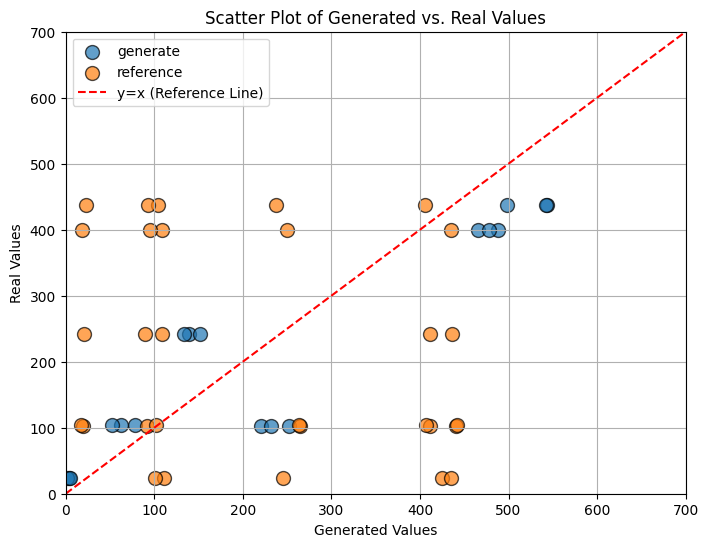

In [58]:
k_max = 700
plt.figure(figsize=(8, 6))  # Increase figure size

# Increase marker size and add edge color for better visibility
plt.scatter(k_gen, k_real, label='generate', s=100, edgecolor='black', alpha=0.7)
plt.scatter(k_compare, k_compare_real, label='reference', s=100, edgecolor='black', alpha=0.7)
plt.plot([0, k_max], [0, k_max], linestyle='--', color='red', label='y=x (Reference Line)')

plt.xlim([0, k_max])
plt.ylim([0, k_max])
plt.xlabel('Generated Values')
plt.ylabel('Real Values')
plt.title('Scatter Plot of Generated vs. Real Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines for better readability
plt.show()



In [36]:
def plot_figure_air(kr_results_real, kr_results_pred, sim_results):
    f = plt.figure()
    # Using 'yo-' for yellow dots with a line, making the line thicker for visibility
    plt.plot(kr_results_real['snw'], kr_results_real['kr_air'], 'yo-', linewidth=4, label='real')

    for ensemble in kr_results_pred:
        if not ensemble:
            continue
        # Using 'r*-' for red stars with a line, specifying a smaller line width
        plt.plot(ensemble['snw'], ensemble['kr_air'], 'r*:', linewidth=3, label='pred')

    # Plot comparison
    compare_phys = sim_results['compare']
    for compare in compare_phys:
        if not compare:
            continue
        # Using 'g.' for gray dots, no connecting line, and specifying marker size for smaller appearance
        plt.plot(compare['snw'], compare['kr_air'], 'g--', color='gray', markersize=5, label='compare')

    plt.title('Relative Permeability of Air')
    plt.show()



def plot_figure_water(kr_results_real, kr_results_pred, sim_results):
    f = plt.figure()
    # Using 'yo-' for yellow dots with a line, making the line thicker for visibility
    plt.plot(kr_results_real['snw'], kr_results_real['kr_water'], 'yo-', linewidth=4, label='real')

    for ensemble in kr_results_pred:
        if not ensemble:
            continue
        # Using 'r*-' for red stars with a line, specifying a smaller line width
        plt.plot(ensemble['snw'], ensemble['kr_water'], 'r*:', linewidth=3, label='pred')

    # Plot comparison
    compare_phys = sim_results['compare']
    for compare in compare_phys:
        if not compare:
            continue
        # Using 'g.' for gray dots, no connecting line, and specifying marker size for smaller appearance
        plt.plot(compare['snw'], compare['kr_water'], 'g--', color='gray', markersize=5, label='compare')
    plt.title('Relative Permeability of Water')
    plt.show()

#### Relative perm checkout

/tmp/ipykernel_716040/2160990826.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_air'], 'g--', color='gray', markersize=5, label='compare')


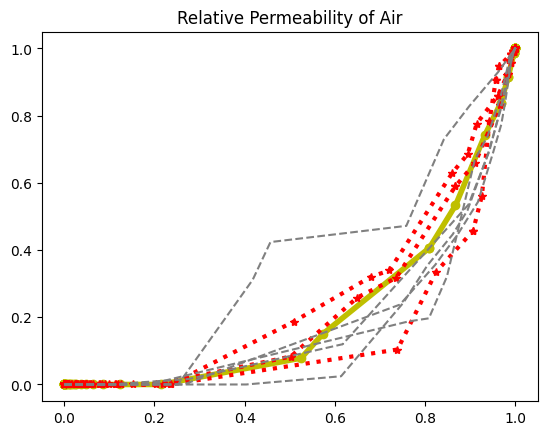

/tmp/ipykernel_716040/2160990826.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_water'], 'g--', color='gray', markersize=5, label='compare')


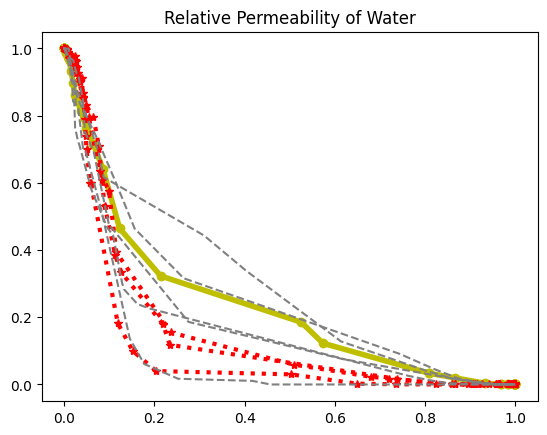

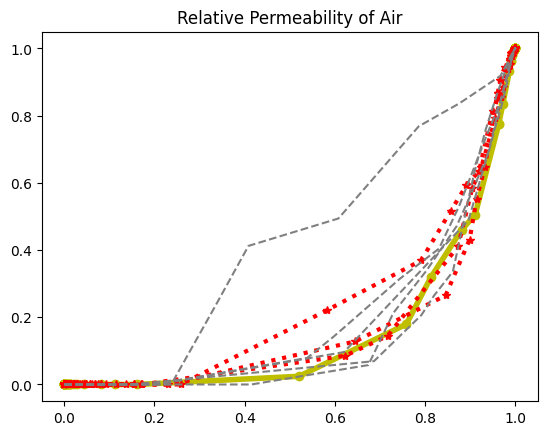

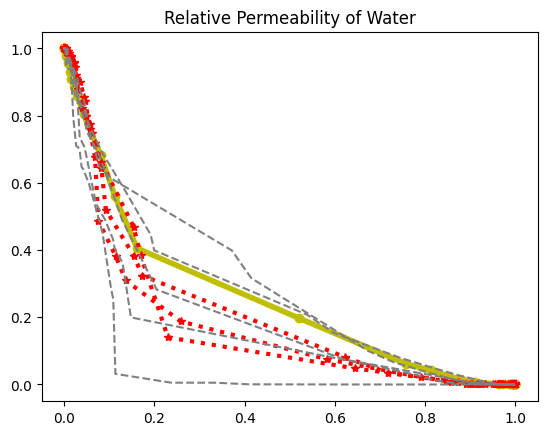

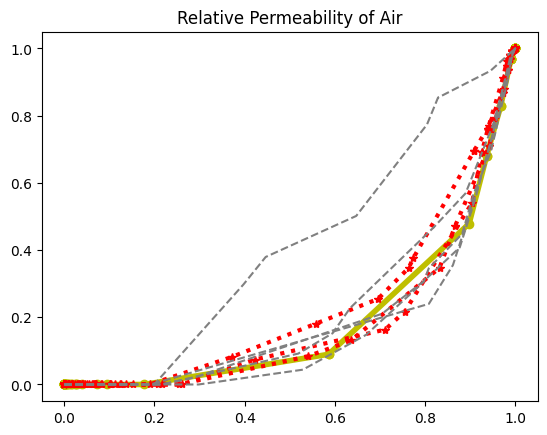

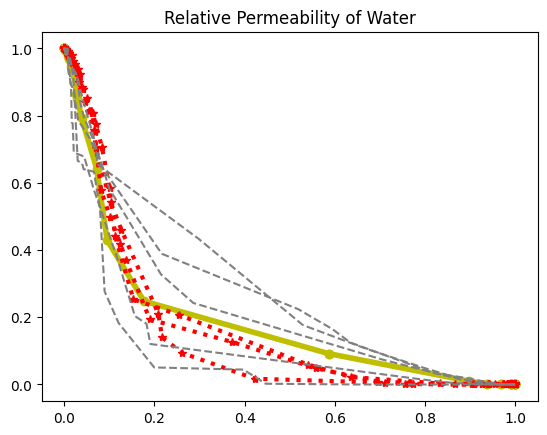

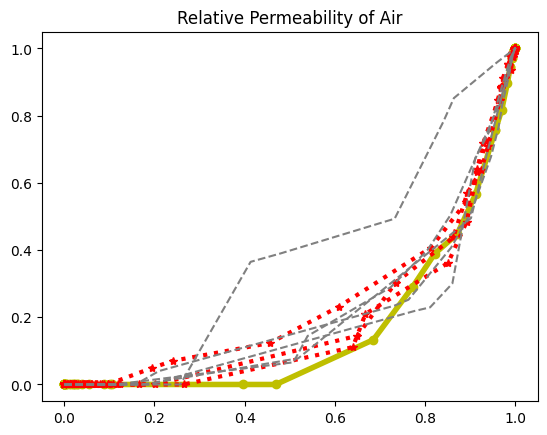

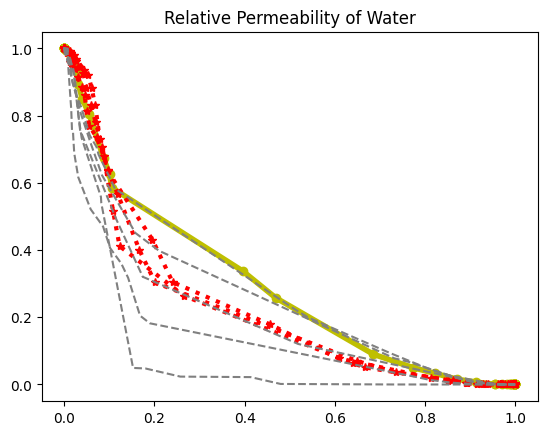

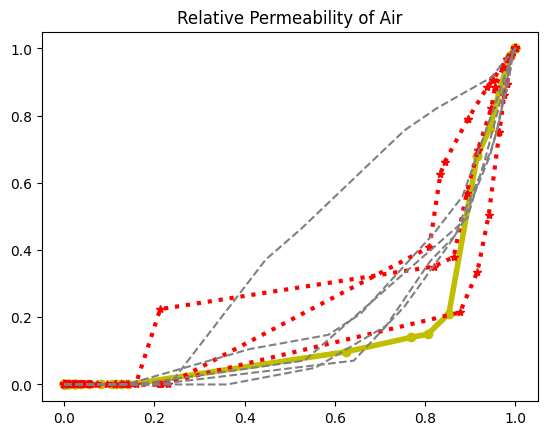

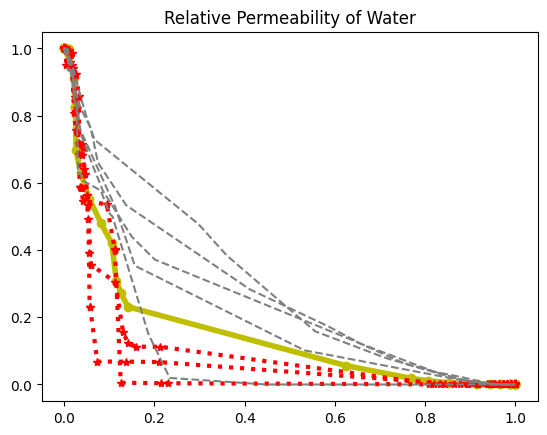

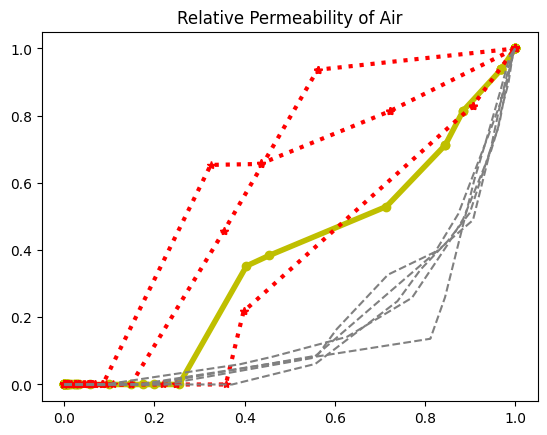

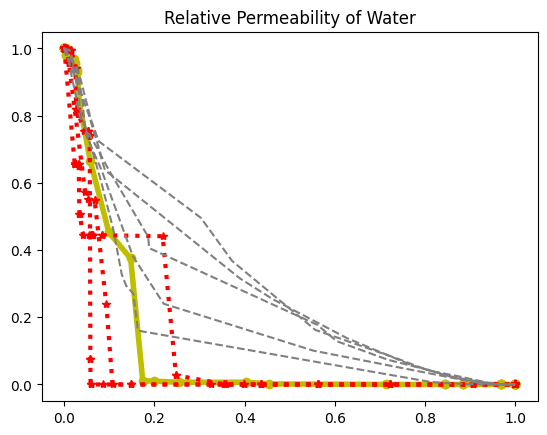

In [47]:

for ct_idx in range(6):
    with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
        # Deserialize the data from the file and assign it to a variable
        sim_results = pickle.load(file)



    # plot original kr
    sample_idx = 0
    kr_results_real = sim_results[sample_idx]['original']
    kr_results_pred = sim_results[sample_idx]['generate'][:]

    plot_figure_air(kr_results_real, kr_results_pred, sim_results)
    plot_figure_water(kr_results_real, kr_results_pred, sim_results)

/tmp/ipykernel_716040/2160990826.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_air'], 'g--', color='gray', markersize=5, label='compare')


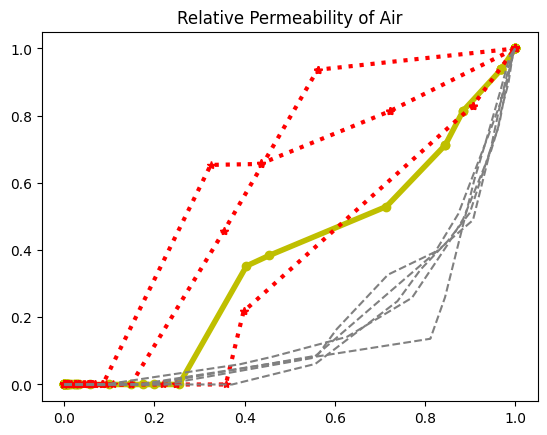

/tmp/ipykernel_716040/2160990826.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_water'], 'g--', color='gray', markersize=5, label='compare')


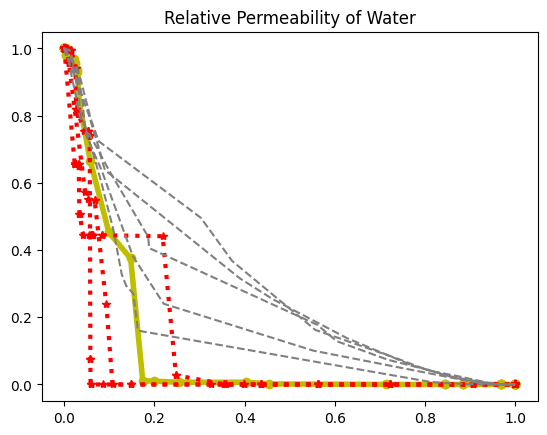

#### Check Vol_dim = 3

$64*3$ -> $192^3$

In [60]:
ct_id = 1
vol_dim = 3
with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)

# plot original kr
sample_idx = 0
kr_results_real = sim_results[sample_idx]['original']
kr_results_pred = sim_results[sample_idx]['generate'][:6]

plot_figure_air(kr_results_real, kr_results_pred, sim_results)
plot_figure_water(kr_results_real, kr_results_pred, sim_results)

TypeError: 'NoneType' object is not subscriptable

<Figure size 640x480 with 0 Axes>